# <center>Hodgkin-Huxley Model Implementation with BrainPy </center>
<center>王宇哲 1800011828
<center>College of Chemistry and Molecular Engineering, Peking University

本次作业通过BrainPy库实现经典的Hodgkin-Huxley神经元模型（HH model）。首先import必要的python module。

In [16]:
import brainpy as bp
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

下面对HH model的原理作一简述。HH model是一个通过非线性微分方程组描述动作电位在单个神经元中的产生和传播的数学模型，具体地，膜电位产生的离子机制可以用下面的电路描述:
![HH Model Circuit](HH-circuit.png)
其中细胞膜的磷脂双层用电容$C$表示，电阻$R_{Na}$、$R_{K}$、$R$分别表示$\rm Na^{+}$、$\rm K^{+}$和其他离子通道，$E_{Na}$、$E_{K}$、$E_{L}$分别表示特定离子浓度差下的reversal potential.对于上述电路，我们有
$$
C\frac{dV}{dt}=-(I_{Na}+I_{K}+I_{leak})+I(t)
$$
即
$$
C\frac{dv}{dt}=-\sum_{k}I_{ion,k} + I(t)
$$
由Ohm's Law，有
$$
I_{x}=g_{x}(V-E_{x}), \ \ x\in \{Na, K, leak\}
$$
其中$x$是特定的离子通道。对于$\rm Na^{+}$和$\rm K^{+}$，有
$$
g_{Na}=\bar{g_{Na}}m^{3}h, \ \ m,h\in [0,1]
$$
$$
g_{K}=\bar{g_{K}}n^{4},\ \ n \in [0,1]
$$
对于任意的$x$，有
$$
\frac{dx}{dt}=-\frac{x-x_{0}(V)}{\tau_{x}(V)}=\alpha_{x}(1-x)-\beta_{x}x
$$
对于$m$、$h$、$n$，$\alpha$和$\beta$由下式给出：
$$
\alpha_{m}(V)=\frac{0.1(V+40)}{1-e^{-\frac{V+40}{10}}}
$$
$$
\beta_{m}(V)=4.0 e^{-\frac{V+65}{18}}
$$
$$
\alpha_{h}(V)=0.07 e^{-\frac{V+65}{20}}
$$
$$
\beta_{h}(V)=\frac{1}{1+ e^{-\frac{V+35}{10}}}
$$
$$
\alpha_{n}(V)=\frac{0.01(V+55)}{1- e^{-\frac{V+55}{10}}}
$$
$$
\beta_{n}(V)=0.125 e^{-\frac{V+65}{80}}
$$

根据以上数学推导，使用BrainPy的ODE numerical solver模块odeint进行代码实现如下，选取方法为4阶Runge-Kutta方法，设定数值积分精度(numerical precision) $dt=0.01$。

In [29]:
@bp.odeint(method='rk4', dt=0.01)
def integral(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C):
    alpha = 0.1 * (V + 40) / (1 - bp.math.exp(-(V + 40) / 10))
    beta = 4.0 * bp.math.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m

    alpha = 0.07 * bp.math.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bp.math.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h

    alpha = 0.01 * (V + 55) / (1 - bp.math.exp(-(V + 55) / 10))
    beta = 0.125 * bp.math.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n

    I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
    I_K = (gK * n ** 4.0) * (V - EK)
    I_leak = gL * (V - EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / C

    return dVdt, dmdt, dhdt, dndt

根据神经细胞实际的生理环境，设定ODE中各个参数如下。

In [30]:
Iext=10.;   ENa=50.;   EK=-77.;   EL=-54.387
C=1.0;      gNa=120.;  gK=36.;    gL=0.03

对ODE进行数值求解，作出$v,m,h,n$关于时间$t$的变化，如下图所示。

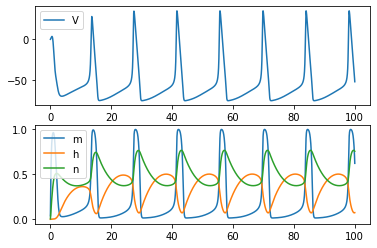

In [31]:
hist_times = bp.math.arange(0, 100, 0.01)
hist_V, hist_m, hist_h, hist_n = [], [], [], []
V, m, h, n = 0., 0., 0., 0.
for t in hist_times:
    V, m, h, n = integral(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C)
    hist_V.append(V)
    hist_m.append(m)
    hist_h.append(h)
    hist_n.append(n)
    
plt.subplot(211)
plt.plot(hist_times, hist_V, label='V')
plt.legend()
plt.subplot(212)
plt.plot(hist_times, hist_m, label='m')
plt.plot(hist_times, hist_h, label='h')
plt.plot(hist_times, hist_n, label='n')
plt.legend()
plt.show()

需要说明的是，odeint模块的数值积分精度$dt$与作图时的时间间隔均需要恰当选取，否则可能无法复现上述HH model，例如：

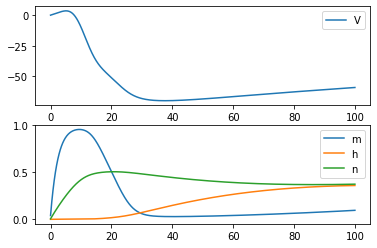

In [32]:
hist_times = bp.math.arange(0, 100, 0.1) # 改变ode数值求解与作图时的时间间隔
hist_V, hist_m, hist_h, hist_n = [], [], [], []
V, m, h, n = 0., 0., 0., 0.
for t in hist_times:
    V, m, h, n = integral(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C)
    hist_V.append(V)
    hist_m.append(m)
    hist_h.append(h)
    hist_n.append(n)
    
plt.subplot(211)
plt.plot(hist_times, hist_V, label='V')
plt.legend()
plt.subplot(212)
plt.plot(hist_times, hist_m, label='m')
plt.plot(hist_times, hist_h, label='h')
plt.plot(hist_times, hist_n, label='n')
plt.legend()
plt.show()

可见上图未能很好地复现HH model中$v,m,h,n$随时间$t$的变化。

此外，HH model还可以通过类继承

In [ ]:
class HH(bp.NeuGroup)

的方式进行实现，如课件所示。该方式实现的HH model考虑了神经元的发放阈值，对神经元是否产生膜电位进行判断，限于篇幅，在本报告中不再进行复现。